In [235]:
import pandas as pd
import numpy as np
import altair as alt
pd.set_option('display.max_columns', 100)


1. To what extent do college sporting event outcomes correlate to reportable incidents?
1. Is Michigan State's campus more prone to incidents (correlated to the timing of sporting events) compared to Michigan?
1. What types of incidents are correlated to sport event outcomes?
1. Do games at certain times of the season have a correlation to frequency of incidents more than others?
1. "Do games at certain times" have a stronger correlation to incidents than other game times?



[Game classification](#big_game)\
[Analysis](#analysis)\
[Correlations](#corrs)\
[Distributions](#distributions)


In [236]:
df = pd.read_csv('../04_finaldata/full_data.csv', parse_dates=['start_dt','incident_date'])

# rename columns
df.rename({'start_dt': 'start', 'season_type': 'type', 'team_points': 'school_points', 'result': 'school_result',
           'ot': 'overtime', 'rank': 'school_rank', 'end_inc_window': 'end_window', 'opp_points': 'opponent_points'}, 
          axis=1, 
          inplace=True
         )

# reorder columns
df = df[['sport', 'school', 'opponent', 'game_id', 'start', 'incident_date', 'end_window', 'type', 'school_result', 
         'school_points', 'opponent_points', 'overtime', 'excitement_index', 'school_rank', 
         'opponent_rank', 'attendance', 'venue', 'incident_id', 'offense_id', 'offense_name']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730 entries, 0 to 6729
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sport             6730 non-null   object        
 1   school            6730 non-null   object        
 2   opponent          6730 non-null   object        
 3   game_id           6730 non-null   int64         
 4   start             6730 non-null   datetime64[ns]
 5   incident_date     6690 non-null   datetime64[ns]
 6   end_window        6730 non-null   object        
 7   type              6730 non-null   object        
 8   school_result     6730 non-null   int64         
 9   school_points     6730 non-null   int64         
 10  opponent_points   6730 non-null   int64         
 11  overtime          6730 non-null   int64         
 12  excitement_index  2452 non-null   float64       
 13  school_rank       5188 non-null   object        
 14  opponent_rank     2209 n

In [237]:
# sort 'df' in chronological order
df = df.sort_values('start')

In [238]:
df['school'] = df['school'].replace('michigan-state', 'michigan state') # rename 'michigan-state' to 'michigan state'

In [239]:
# calculate score difference
df['score_diff'] = df['school_points'] - df['opponent_points']

In [240]:
# replace '-' characters w/ np.nan
df['school_rank'] = df['school_rank'].replace('-', np.nan)
df['opponent_rank'] = df['opponent_rank'].replace('-', np.nan)

In [241]:
# convert columns to floats
df['school_rank'] = df['school_rank'].astype('float')
df['opponent_rank'] = df['opponent_rank'].astype('float')

In [242]:
df['incident_date'] = pd.to_datetime(df['incident_date']) # convert 'incident_date' to datetime
df['incident_hour'] = df['incident_date'].dt.hour # create 'incident_hour' column
df['incident_month'] = df['incident_date'].dt.month # create 'incident_month' column

In [243]:
df['incident_hour'].isnull().value_counts() # how many rows have NaT from no incident available?

False    6690
True       40
Name: incident_hour, dtype: int64


#### Crime family classifications


In [244]:
# DataFrame w/ number of incidents per game as column
# will be 0 if no incident is found
df['incident_count'] = df.groupby(['game_id'])['incident_id'].transform('count')

In [245]:
df['offense_name'].value_counts()

Destruction/Damage/Vandalism of Property       1005
Simple Assault                                  795
Theft From Building                             752
All Other Larceny                               579
Drug/Narcotic Violations                        572
Theft From Motor Vehicle                        550
Burglary/Breaking & Entering                    491
Shoplifting                                     315
Aggravated Assault                              230
Arson                                           186
False Pretenses/Swindle/Confidence Game         138
Intimidation                                    119
Credit Card/Automated Teller Machine Fraud      118
Motor Vehicle Theft                             118
Rape                                             98
Robbery                                          90
Theft of Motor Vehicle Parts or Accessories      78
Identity Theft                                   67
Fondling                                         53
Counterfeiti

In [246]:
offense_groups = {'Theft From Building': 'Theft', 
                  'Drug/Narcotic Violations': 'Substance Violation', 
                  'Simple Assault': 'Physical', 
                  'Destruction/Damage/Vandalism of Property': 'Property', 
                  'All Other Larceny': 'Theft',
                  'Theft From Motor Vehicle': 'Theft',
                  'Burglary/Breaking & Entering': 'Theft',
                  'Aggravated Assault': 'Physical',
                  'Intimidation': 'Physical',
                  'False Pretenses/Swindle/Confidence Game': 'Scam',
                  'Credit Card/Automated Teller Machine Fraud': 'Scam',
                  'Counterfeiting/Forgery': 'Scam',
                  'Fondling': 'Sexual',
                  'Motor Vehicle Theft': 'Theft',
                  'Robbery': 'Theft',
                  'Rape': 'Sexual',
                  'Shoplifting': 'Theft',
                  'Pocket-picking': 'Theft',
                  'Arson': 'Property',
                  'Stolen Property Offenses': 'Property',
                  'Theft of Motor Vehicle Parts or Accessories': 'Theft',
                  'Extortion/Blackmail': 'Scam',
                  'Theft From Coin-Operated Machine or Device': 'Theft',
                  'Sexual Assault With An Object': 'Sexual',
                  'Weapon Law Violations': 'Weapon Violation',
                  'Drug Equipment Violations': 'Substance Violation',
                  'Purse-snatching': 'Theft',
                  'Sodomy': 'Sexual',
                  'Embezzlement': 'Scam',
                  'Identity Theft': 'Scam',
                  'Impersonation': 'Scam',
                  'Animal Cruelty': 'Animal Cruelty',
                  'Wire Fraud': 'Scam',
                  'Kidnapping/Abduction': 'Physical',
                 }

df['offense_map'] = df['offense_name'].map(offense_groups) 

In [247]:
one_hot = pd.get_dummies(df['offense_map'])
df = pd.concat([df, one_hot], axis=1)

In [248]:
# crime group for game w/ sum for game in each row 
for crime in df['offense_map'].unique():
    if type(crime) == type('str'): # only accept strings and ignore np.nan
        df[crime+' sum'] = df.groupby(['game_id'])[crime].transform('sum')

In [249]:
# check to see transform loop worked:
# df.iloc[10:20, [3, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]]


#### Poll rank column designations


In [250]:
rank_list = [25, 20, 15, 10, 5]
for rank in rank_list:
    df['top_' + str(rank) + '_matchup'] = np.where((df['school_rank'] <= rank) & (df['opponent_rank'] <= rank), 1, 0)

In [251]:
df[df['top_5_matchup'] == 1][['school', 'opponent', 'school_rank', 'opponent_rank', 'top_5_matchup']][:10]

,school,opponent,school_rank,opponent_rank,top_5_matchup
4057,michigan,indiana (3),1.0,3.0,1
4058,michigan,indiana (3),1.0,3.0,1
4059,michigan,indiana (3),1.0,3.0,1
4060,michigan,indiana (3),1.0,3.0,1
4061,michigan,indiana (3),1.0,3.0,1
4062,michigan,indiana (3),1.0,3.0,1
4063,michigan,indiana (3),1.0,3.0,1
558,michigan state,indiana (1),4.0,1.0,1
559,michigan state,indiana (1),4.0,1.0,1
560,michigan state,indiana (1),4.0,1.0,1


In [252]:
df['poll_diff'] = df['school_rank'] - df['opponent_rank']


#### LabelEncoder()


In [253]:
df['score_quantile'] = pd.qcut(df['score_diff'], 4, labels=[1, 2, 3, 4])

In [254]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['score_quantile'] = enc.fit_transform(df['score_quantile'])
df['score_quantile'].unique()

array([3, 1, 0, 2])

In [255]:
enc = LabelEncoder()
df['venue_enc'] = enc.fit_transform(df['venue'])
df['venue_enc'].unique()

array([17, 10, 11,  3,  9,  6, 19, 21, 15, 16,  2, 12,  5, 13,  1,  4,  8,
       14, 20,  7,  0, 18])

In [256]:
df['venue_enc'].replace(17, 23, inplace=True)
df['venue_enc'].replace(10, 24, inplace=True)

In [257]:
df[['venue', 'venue_enc']]

,venue,venue_enc
1271,Spartan Stadium,23
1270,Spartan Stadium,23
1269,Spartan Stadium,23
1268,Spartan Stadium,23
1267,Spartan Stadium,23
...,...,...
2128,Spartan Stadium,23
2129,Spartan Stadium,23
2130,Spartan Stadium,23
2131,Spartan Stadium,23


In [258]:
df['venue_enc'].unique()

array([23, 24, 11,  3,  9,  6, 19, 21, 15, 16,  2, 12,  5, 13,  1,  4,  8,
       14, 20,  7,  0, 18])

In [259]:
df[['score_diff', 'score_quantile']].sample(30)

,score_diff,score_quantile
4271,-7,0
3487,5,1
592,16,2
643,10,2
3506,-7,0
6438,23,3
1713,3,1
1891,10,2
153,-9,0
1730,-4,0


In [260]:
# groupby_gameid = df.groupby('game_id') # this is used nowhere else - should toss


<a id='big_game'></a>



&nbsp;

## Game classification


In [261]:
# https://stackoverflow.com/questions/30631841/pandas-how-do-i-assign-values-based-on-multiple-conditions-for-existing-columns

conditions = [
    df['top_5_matchup'].eq(1),
    df['top_10_matchup'].eq(1),
    df['top_15_matchup'].eq(1),
    df['top_20_matchup'].eq(1),
    df['top_25_matchup'].eq(1)
]

choices = [1, 2, 3, 4, 5]

df['top_matchup'] = np.select(conditions, choices, default=np.nan)

In [262]:
conditions = [df['school'].eq('michigan') 
              & df['opponent'].isin(['ohio state', 'notre dame', 'michigan state', 'michigan-state']), 
              df['school'].eq('michigan state') & df['opponent'].isin(['michigan'])
             ]

choices = [1, 1]
df['rivalry'] = np.select(conditions, choices, default=0)


&nbsp;


In [263]:
# create a DataFrame where counts of incidents + crime types are counted / summed, and each game is a single row
df_onerow = df.drop_duplicates('game_id')

<a id='analysis'></a>


&nbsp;

## Analysis


In [264]:
df[df.incident_date.isnull()][:5]

,sport,school,opponent,game_id,start,incident_date,end_window,type,school_result,school_points,opponent_points,overtime,excitement_index,school_rank,opponent_rank,attendance,venue,incident_id,offense_id,offense_name,score_diff,incident_hour,incident_month,incident_count,offense_map,Animal Cruelty,Physical,Property,Scam,Sexual,Substance Violation,Theft,Weapon Violation,Property sum,Physical sum,Theft sum,Substance Violation sum,Scam sum,Sexual sum,Weapon Violation sum,Animal Cruelty sum,top_25_matchup,top_20_matchup,top_15_matchup,top_10_matchup,top_5_matchup,poll_diff,score_quantile,venue_enc,top_matchup,rivalry
294,basketball,michigan state,massachusetts,633,2009-11-28 17:30:00,NaT,2009-11-29 03:30:00,regular,1,106,68,0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,38,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,3,21,NaN,0
3622,basketball,michigan state,oakland,637,2009-12-10 19:00:00,NaT,2009-12-11 05:00:00,regular,1,88,57,0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,31,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,3,21,NaN,0
2321,basketball,michigan state,minnesota,644,2010-01-13 18:30:00,NaT,2010-01-14 04:30:00,regular,1,60,53,0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,1,21,NaN,0
2151,basketball,michigan state,wisconsin (16),650,2010-02-02 21:00:00,NaT,2010-02-03 07:00:00,regular,0,49,67,0,NaN,5.0,16.0,NaN,NaN,NaN,NaN,NaN,-18,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,-11.0,0,21,4.0,0
1310,basketball,michigan state,duke (1),671,2010-12-01 21:30:00,NaT,2010-12-02 07:30:00,regular,0,79,84,0,NaN,6.0,1.0,NaN,NaN,NaN,NaN,NaN,-5,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,5.0,0,21,2.0,0


In [265]:
len(df[df.incident_date.isnull()]['game_id'].drop_duplicates()) # check NaT values each belong to games w/ no incidents

40

In [266]:
# what's the mean number of incidents generated from football rivlary games?
for sport in df['sport'].unique():
    print(df[(df['rivalry'] == 1) 
             & (df['sport'] == sport)
            ]
          .groupby('start')['incident_id'].agg('count').mean(),
          'incidents on average for ' + sport + ' rivalry games')

22.0 incidents on average for football rivalry games
5.0625 incidents on average for basketball rivalry games



&nbsp;

#### Testing


In [267]:
# before
print(len(df[df['top_' + str(25) + '_matchup'] == 1]) / len(df))

0.18543833580980684


In [268]:
# after
notnulltop25 = len(df[(df['top_' + str(25) + '_matchup'] == 1) & (df['incident_date'].notnull())])
notnulls = len(df[df['incident_date'].notnull()])
print(notnulltop25, '\n', notnulls, '\n', (notnulltop25 / notnulls))

1240 
 6690 
 0.18535127055306427



&nbsp;



#### Percentages


In [269]:
# count %age of incidents our of whole for each ranking group
for rank in rank_list:
    print('{:.1%}'.format(len(df[(df['top_' + str(rank) + '_matchup'] == 1) & (df['incident_date'].notnull())]
                             )
                          / len(df[df['incident_date'].notnull()])
                         ), 'of incidents are related to top ' + str(rank) + ' games'
         )

18.5% of incidents are related to top 25 games
14.3% of incidents are related to top 20 games
7.9% of incidents are related to top 15 games
4.7% of incidents are related to top 10 games
1.0% of incidents are related to top 5 games


In [270]:
# how many games in the entire set were top 25 matchups, top 20 matchups...
for rank in rank_list:
    print(len(df_onerow[df_onerow['top_' + str(rank) + '_matchup'] == 1]), 
          'out of', 
          len(df_onerow), 
          ' top ' + str(rank) + ' matchups -', 
          '{:.1%}'.format(len(df_onerow[df_onerow['top_' + str(rank) + '_matchup'] == 1]) / len(df_onerow)), 'percent')

166 out of 993  top 25 matchups - 16.7% percent
130 out of 993  top 20 matchups - 13.1% percent
74 out of 993  top 15 matchups - 7.5% percent
42 out of 993  top 10 matchups - 4.2% percent
9 out of 993  top 5 matchups - 0.9% percent


In [271]:
# what %age of incidents are associated w/ ranked games when Michigan or Michigan State lost?
print('For games where Michigan or Michigan State lost:\n')
for rank in rank_list:
    print('{:.1%}'.format(len(df[(df['top_' + str(rank) + '_matchup'] == 1) 
                                 & (df['incident_date'].notnull())
                                 & (df['school_result'] == 0)]) 
                          / len(df[(df['school_result'] == 0) & (df['incident_date'].notnull())])
                         ), 
          'of incidents attributable to top ' + str(rank) + ' games '
         )

For games where Michigan or Michigan State lost:

27.5% of incidents attributable to top 25 games 
22.8% of incidents attributable to top 20 games 
13.7% of incidents attributable to top 15 games 
7.6% of incidents attributable to top 10 games 
1.2% of incidents attributable to top 5 games 


In [272]:
# what %age of incidents are associated w/ ranked games when Michigan or Michigan State won?
print('For games where Michigan or Michigan State won:\n')
for rank in rank_list:
    print('{:.1%}'.format(len(df[(df['top_' + str(rank) + '_matchup'] == 1) 
                                 & (df['incident_date'].notnull())
                                 & (df['school_result'] == 1)])
                          / len(df[(df['school_result'] == 1) & (df['incident_date'].notnull())])
                         ), 
          'of incidents attributable to top ' + str(rank) + ' games '
         )

For games where Michigan or Michigan State won:

14.6% of incidents attributable to top 25 games 
10.6% of incidents attributable to top 20 games 
5.4% of incidents attributable to top 15 games 
3.4% of incidents attributable to top 10 games 
0.9% of incidents attributable to top 5 games 



&nbsp;

#### Where losses occurred


In [273]:
df_cfbl = df[(df['school_result'] == 0) 
                & (df['sport'] == 'football') 
                & (df['incident_date'].notnull()) # drop rows w/out incidents (NaT values)
               ]

# what about if it's just football losses?
print('For football games where Michigan or Michigan State lost:\n')
for rank in rank_list:
    print('{:.1%}'.format(len(df_cfbl[df_cfbl['top_' + str(rank) + '_matchup'] == 1]) 
                          / len(df_cfbl)
                         ), 
          'top ' + str(rank) + ' CFB where Michigan / Michigan State lost'
         )

For football games where Michigan or Michigan State lost:

34.8% top 25 CFB where Michigan / Michigan State lost
28.9% top 20 CFB where Michigan / Michigan State lost
17.2% top 15 CFB where Michigan / Michigan State lost
8.4% top 10 CFB where Michigan / Michigan State lost
1.3% top 5 CFB where Michigan / Michigan State lost


In [274]:
# incidents from games where Michigan / Michigan State lost a rivalry game
print('{:.1%}'.format(len(df_cfbl[(df_cfbl['rivalry'] == 1)])
                      / len(df_cfbl)), 
      'of incidents from Michigan / Michigan State CFB games where losses occurred were from rivalry games'
     )

35.8% of incidents from Michigan / Michigan State CFB games where losses occurred were from rivalry games



People tend to react more when it's a rivalry game w/ a loss.



&nbsp;

#### Where wins occurred


In [275]:
df_cfbw = df[(df['school_result'] == 1) 
               & (df['sport'] == 'football') 
               & (df['incident_date'].notnull()) # drop rows w/out an incident )
              ]

# what about if it's just football wins?
for rank in rank_list:
    print('{:.1%}'.format(len(df_cfbw[df_cfbw['top_' + str(rank) + '_matchup'] == 1]) 
                          / len(df_cfbw)
                         ), 
          'top ' + str(rank) + ' CFB where Michigan / Michigan State won'
         )

18.1% top 25 CFB where Michigan / Michigan State won
13.0% top 20 CFB where Michigan / Michigan State won
6.3% top 15 CFB where Michigan / Michigan State won
5.1% top 10 CFB where Michigan / Michigan State won
1.1% top 5 CFB where Michigan / Michigan State won


In [276]:
# winning a football rivalry game?
print('{:.1%}'.format(len(df_cfbw[(df_cfbw['rivalry'] == 1)])
                      / len(df_cfbw)), 'of incidents from Michigan / Michigan State CFB games where wins occurred were from rivalry games')

14.9% of incidents from Michigan / Michigan State CFB games where wins occurred were from rivalry games


In [277]:
# number of incidents from ranked football games Michigan + Michigan State lost
len(df_cfbl[(df_cfbl['top_25_matchup'] == 1)])

340


&nbsp;


In [278]:
# what is the mean number of incidents for top matchups by ranking bracket (25, 20, 15, 10, 5)?
for rank in rank_list:
    print('{:.2f}'.format(df[df['top_' + str(rank) + '_matchup'] == 1]
                          .groupby('start')['incident_id'].agg('count')
                          .mean()
                         ), 
          'mean incidents for a top ' + str(rank) + ' matchup'
         )

8.27 mean incidents for a top 25 matchup
7.99 mean incidents for a top 20 matchup
7.90 mean incidents for a top 15 matchup
8.49 mean incidents for a top 10 matchup
7.56 mean incidents for a top 5 matchup


In [279]:
print('{:.2f}'.format(df[df['sport'] == 'football'].groupby('game_id')['incident_id'].agg('count').mean()), '\n')

# what is the mean number of incidents for top matchups by ranking bracket (25, 20, 15, 10, 5) when it is only football?
for rank in rank_list:
    print('{:.2f}'.format(df[(df['top_' + str(rank) + '_matchup'] == 1) 
                       & (df['sport'] == 'football')]
                    .groupby('start')['incident_id'].agg('count')
                    .mean()
                   ), 
          'mean incidents per game for top ' + str(rank) + ' games'
         )

11.44 

15.57 mean incidents per game for top 25 games
14.50 mean incidents per game for top 20 games
14.90 mean incidents per game for top 15 games
17.09 mean incidents per game for top 10 games
18.00 mean incidents per game for top 5 games


In [280]:
# only two football games were top 5 matchups
(df_onerow[(df_onerow['sport'] == 'football') 
          & (df_onerow['top_5_matchup'] == 1)]
[['school', 'opponent', 'school_rank', 'opponent_rank']])

,school,opponent,school_rank,opponent_rank
1613,michigan state,iowa,5.0,4.0
4724,michigan,ohio state,3.0,2.0


In [281]:
print('{:.2f}'.format(df[df['sport'] == 'basketball']
                      .groupby('game_id')['incident_id'].agg('count')
                      .mean()
                     ),
      'mean incidents for any basketball game \n'
     )

# what is the mean number of incidents for top matchups by ranking bracket (25, 20, 15, 10, 5) when it is only basketball?
for rank in rank_list:
    print('{:.2f}'.format(df[(df['top_' + str(rank) + '_matchup'] == 1) 
                             & (df['sport'] == 'basketball')]
                          .groupby('game_id')['incident_id'].agg('count')
                          .mean()
                         ),
          'mean incidents per game for top ' + str(rank) + ' games'
         )

5.01 mean incidents for any basketball game 

4.56 mean incidents per game for top 25 games
4.53 mean incidents per game for top 20 games
4.36 mean incidents per game for top 15 games
4.06 mean incidents per game for top 10 games
4.57 mean incidents per game for top 5 games


In [282]:
print('{:.2f}'.format(df[(df['rivalry'] == 1) & (df['sport'] == 'basketball')]
                      .groupby('game_id')['incident_id'].agg('count')
                      .mean()
                     ),
      'mean incidents for basketball rivlary games'
     )

3.86 mean incidents for basketball rivlary games



Possible confounding factors exist for basketball, like weather for the time of year and games played mid-week vs. Saturday.



<a id='corrs'></a>



&nbsp;

## Correlations


In [283]:
import matplotlib.pyplot as plt
import seaborn as sns

In [284]:
corr_list = ['school_result', 'start', 'offense_name', 'overtime', 'rivalry', 'top_matchup', 
'excitement_index', 'venue_enc', 'score_quantile', 'incident_count', 'incident_hour', 'incident_month', 
'Theft', 'Scam', 'Property', 'Substance Violation', 'Physical', 'Sexual',
'Weapon Violation', 'Animal Cruelty']

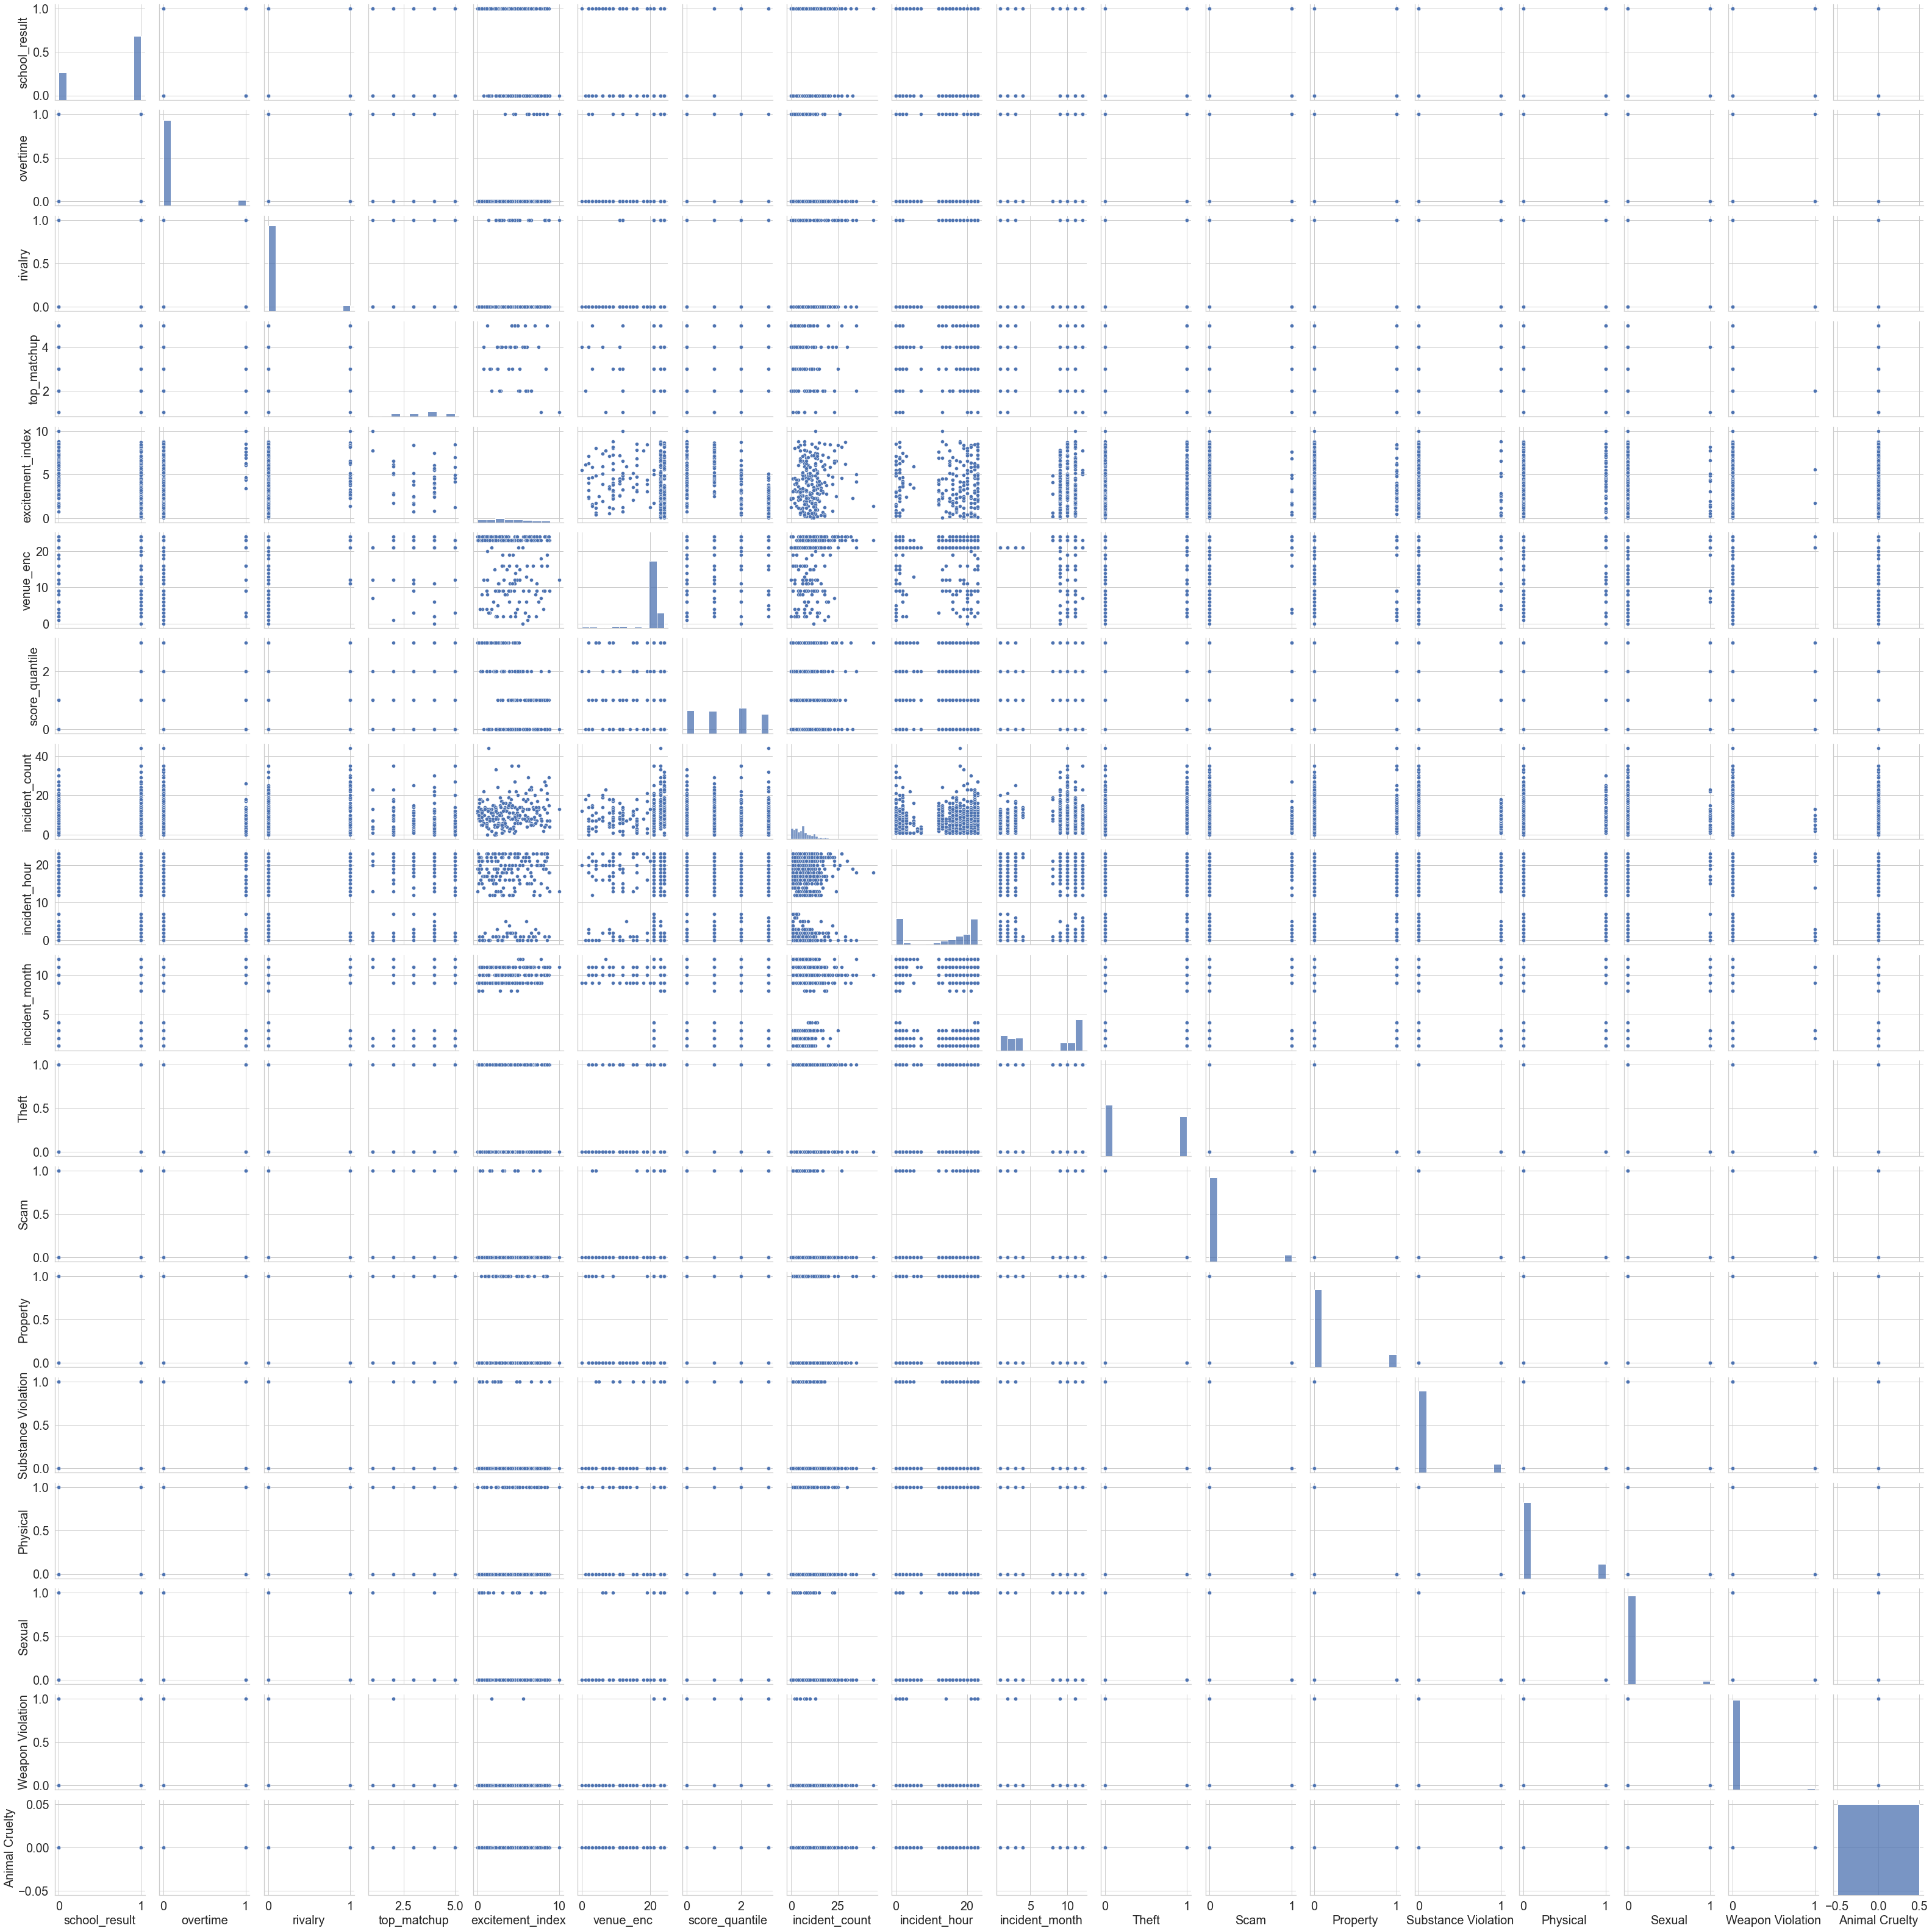

In [285]:
sns.pairplot(df_onerow[corr_list])

In [286]:
len(df_onerow[(df_onerow['sport'] == 'football') & (df_onerow['school'] == 'michigan state')])

135

In [287]:
(df_onerow[(df_onerow['sport'] == 'football') & (df_onerow['school'] == 'michigan state') & (df_onerow['rivalry'] == 1)]
[['school', 'opponent', 'start', 'score_diff', 'rivalry', 'venue', 'Theft sum', 'Physical sum', 'Property sum']]
 .sort_values('Physical sum', ascending=False))[0:50]

,school,opponent,start,score_diff,rivalry,venue,Theft sum,Physical sum,Property sum
6045,michigan state,michigan,2014-10-25 15:30:00,24,1,Spartan Stadium,13,13,13
4391,michigan state,michigan,2018-10-20 12:00:00,-14,1,Spartan Stadium,4,12,2
3698,michigan state,michigan,2009-10-03 12:00:00,6,1,Spartan Stadium,10,7,9
2585,michigan state,michigan,2013-11-02 15:30:00,23,1,Spartan Stadium,11,6,6
3464,michigan state,michigan,2011-10-15 12:00:00,14,1,Spartan Stadium,13,5,10
4803,michigan state,michigan,2016-10-29 12:00:00,-9,1,Spartan Stadium,17,5,10
6088,michigan state,michigan,2010-10-09 15:30:00,17,1,Michigan Stadium,0,3,1
2053,michigan state,michigan,2017-10-07 19:30:00,4,1,Michigan Stadium,2,2,8
3547,michigan state,michigan,2012-10-20 15:30:00,-2,1,Michigan Stadium,2,0,1
1531,michigan state,michigan,2015-10-17 15:30:00,4,1,Michigan Stadium,2,0,3


<AxesSubplot:>

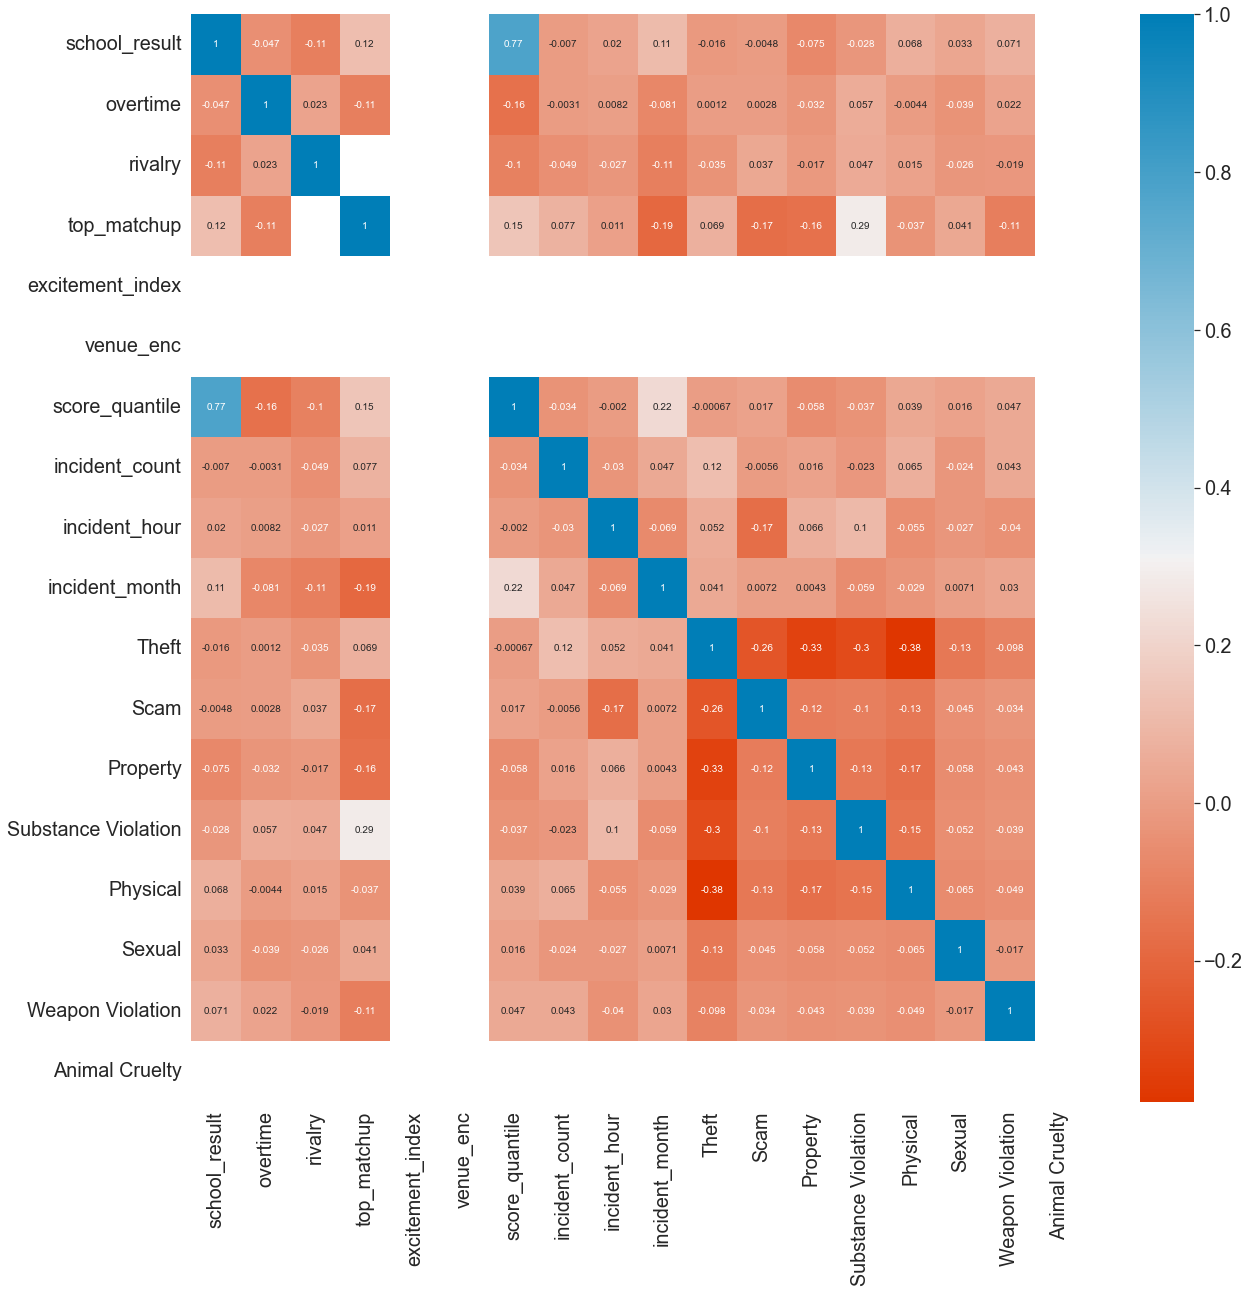

In [288]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap((df_onerow[df_onerow['sport'] == 'basketball']
             [corr_list]
            )
            .corr(method='spearman'), 
            cmap=sns.diverging_palette(16, 240, s=100, l=50, as_cmap=True), 
            annot=True, 
            annot_kws={"fontsize":10}
           )

<AxesSubplot:>

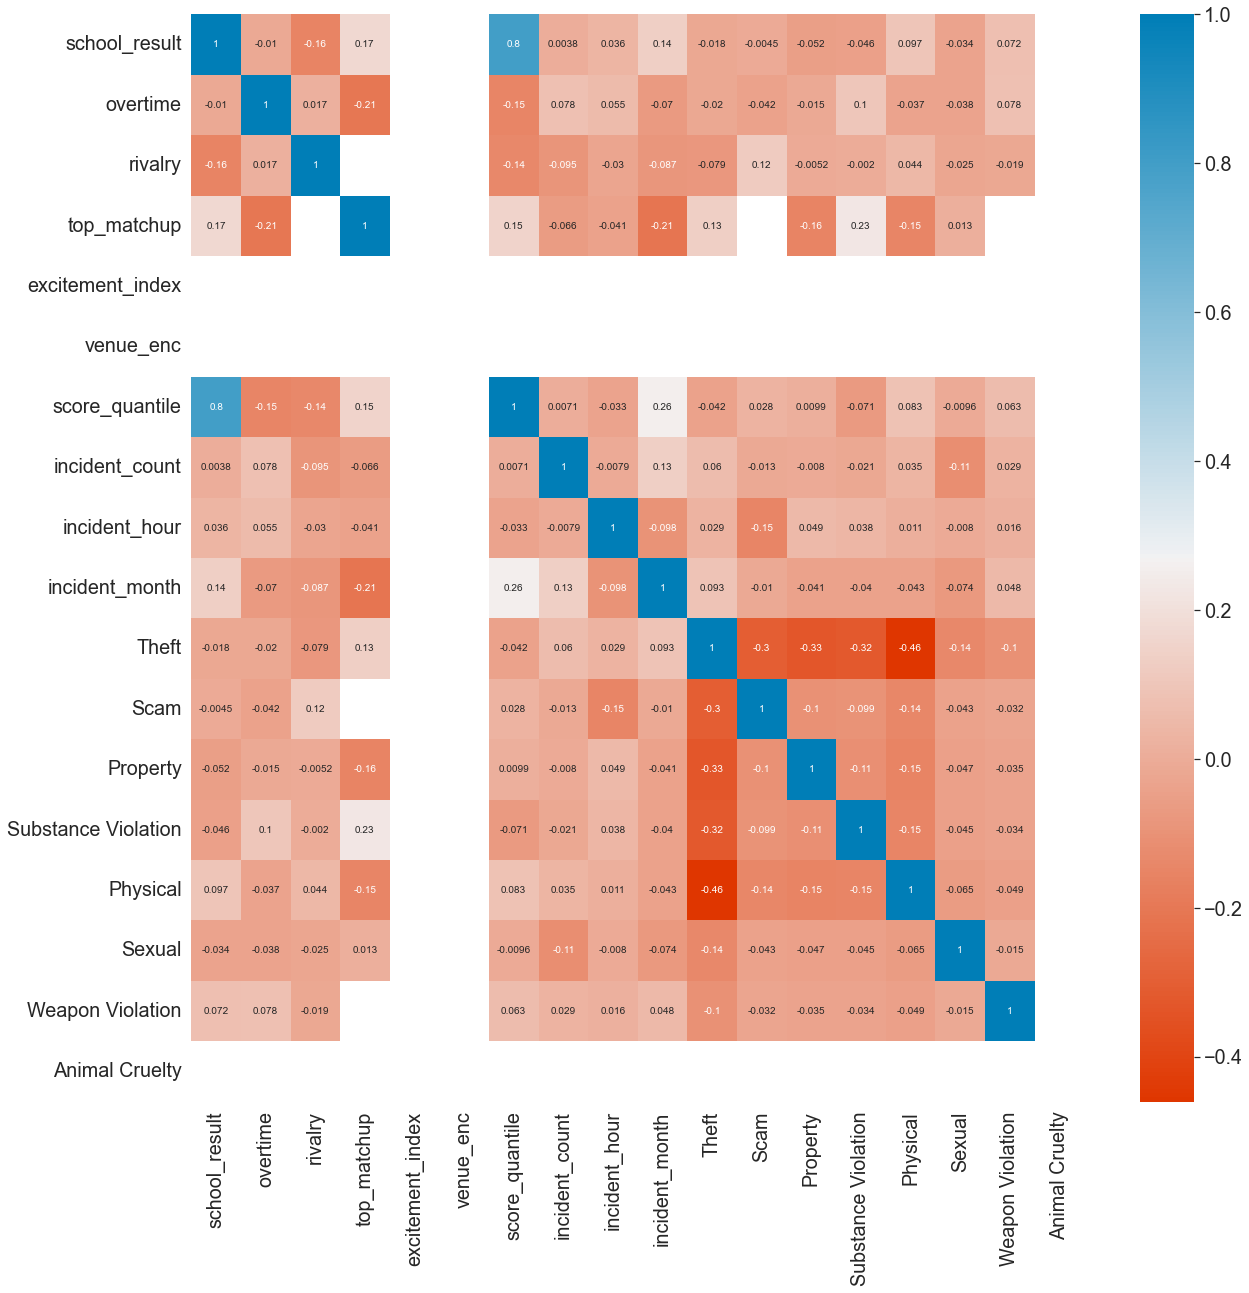

In [289]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(((df_onerow[(df_onerow['sport'] == 'basketball') 
                        & (df_onerow['school'] == 'michigan')]
             )
             [corr_list]
            )
            .corr(method='spearman'), 
            cmap=sns.diverging_palette(16, 240, s=100, l=50, as_cmap=True), 
            annot=True, 
            annot_kws={"fontsize":10}
           )

In [290]:
# Configure a mapping of colors to use for the corrlation matrices
corr_map = sns.color_palette(['#f1c232','#d4ab2c','#be9025','#9d771e','#664e13','#40310c','#201906' ,'#000000'], as_cmap=True)

# Need to tighten the names of substance violations so it fits easier on the plot.
df_corr = df_onerow.copy()
df_corr = df_corr.rename({'Substance Violation':'Substance', 'Weapon Violation':'Weapon'}, axis=1)



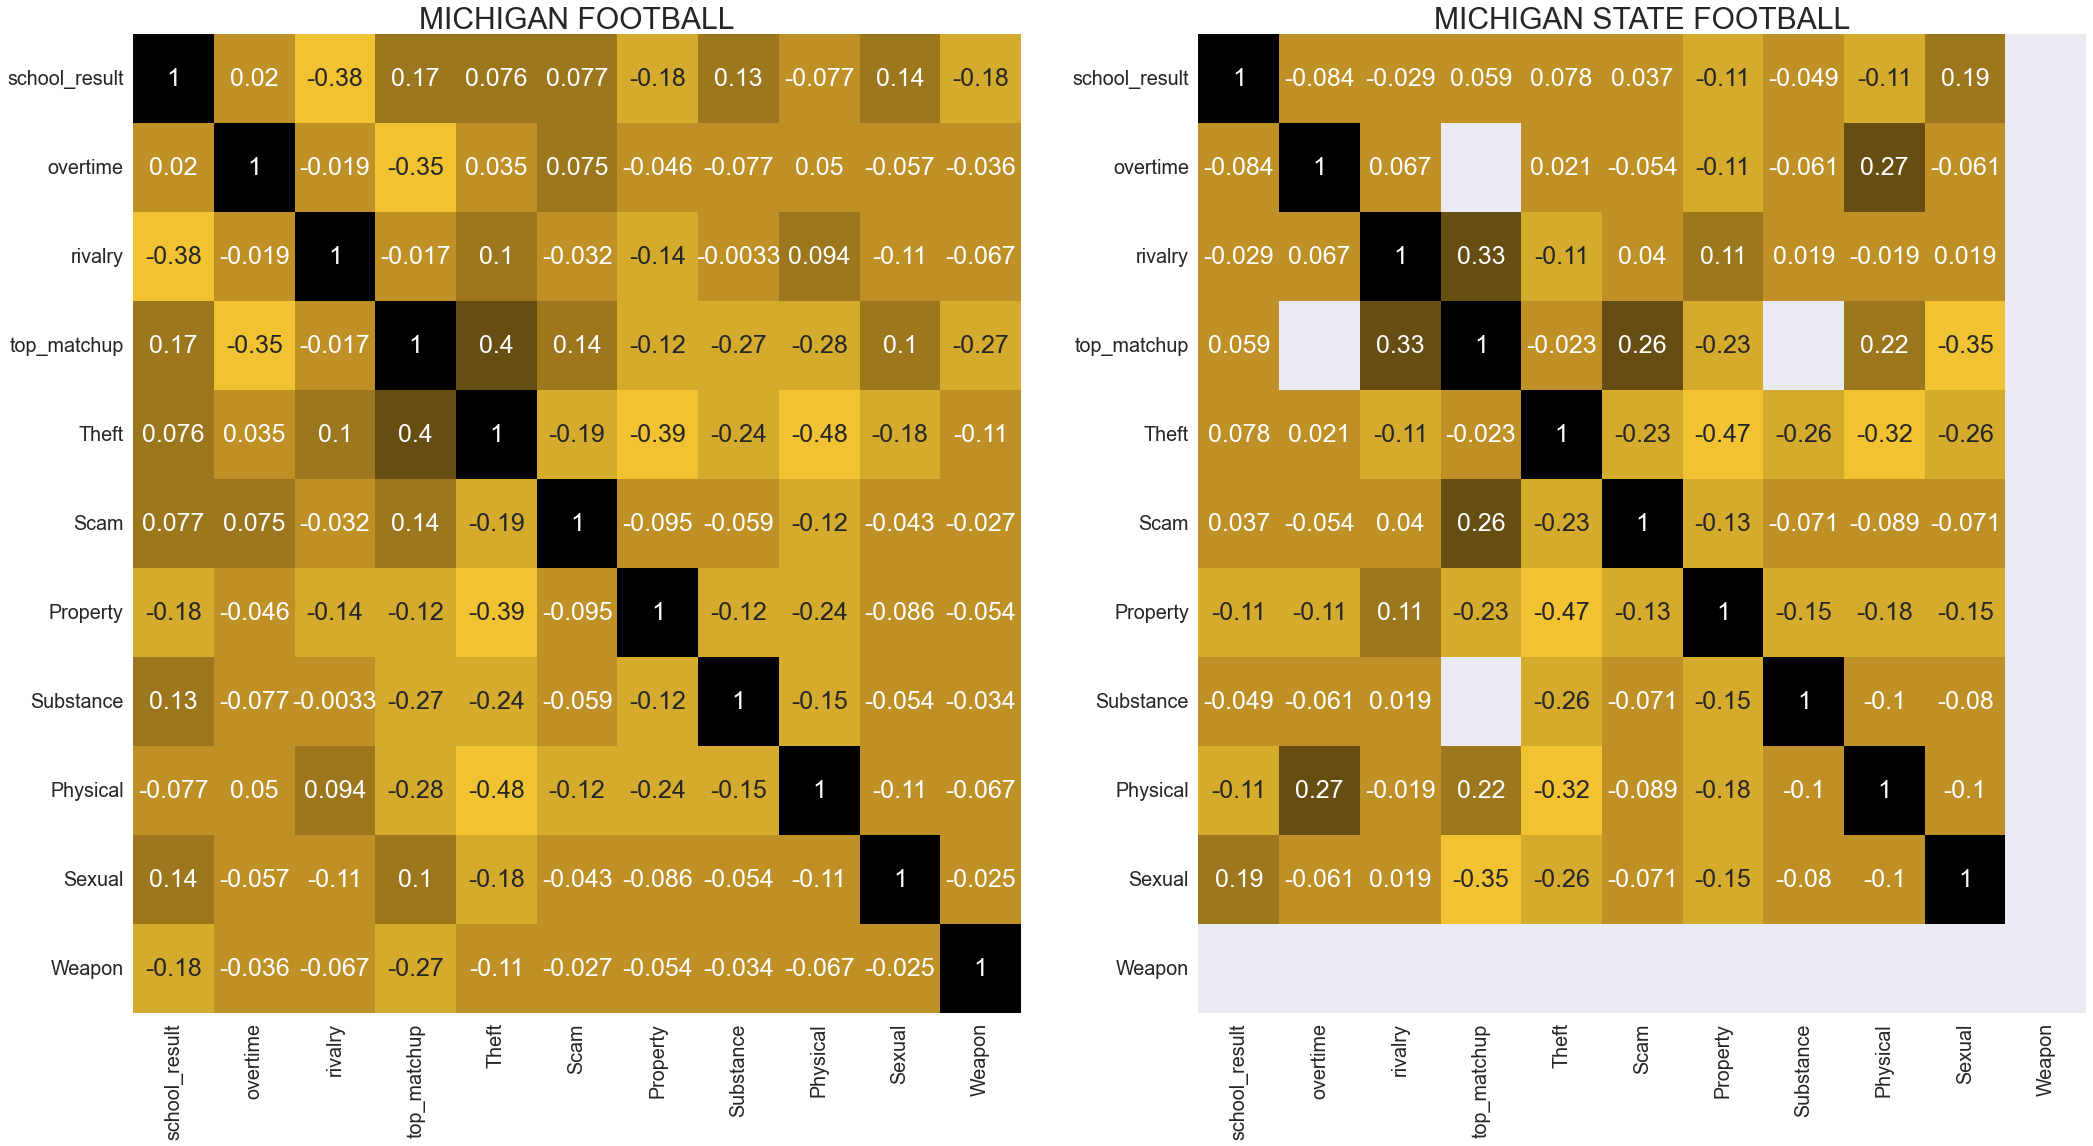

In [291]:

condensed_lst = ['school_result', 'overtime','rivalry','top_matchup','Theft','Scam','Property','Substance', 'Physical', 'Sexual', 'Weapon']



sns.set(font_scale=1.8)



fig, axes =  plt.subplots( 1,2, figsize=(35, 18))
axes = axes.flatten()
for idx, school in enumerate(['michigan', 'michigan state']):
    if idx==0:
        cbar=False
    else:
        cbar=True
    sns.heatmap(((df_corr[(df_corr['sport'] == 'football') 
                            & (df_corr['school'] == school)]
                 )[condensed_lst]
                    )
                    .corr(method='spearman'), 
                    cmap=corr_map,
                    cbar= False,
                    annot=True, 
                    annot_kws={"fontsize":25},
                    ax= axes[idx]
                   )
    axes[idx].set_title(f'{school.upper()} FOOTBALL', fontsize=30)
    
    
plt.savefig('../../cfb_matrix.png')

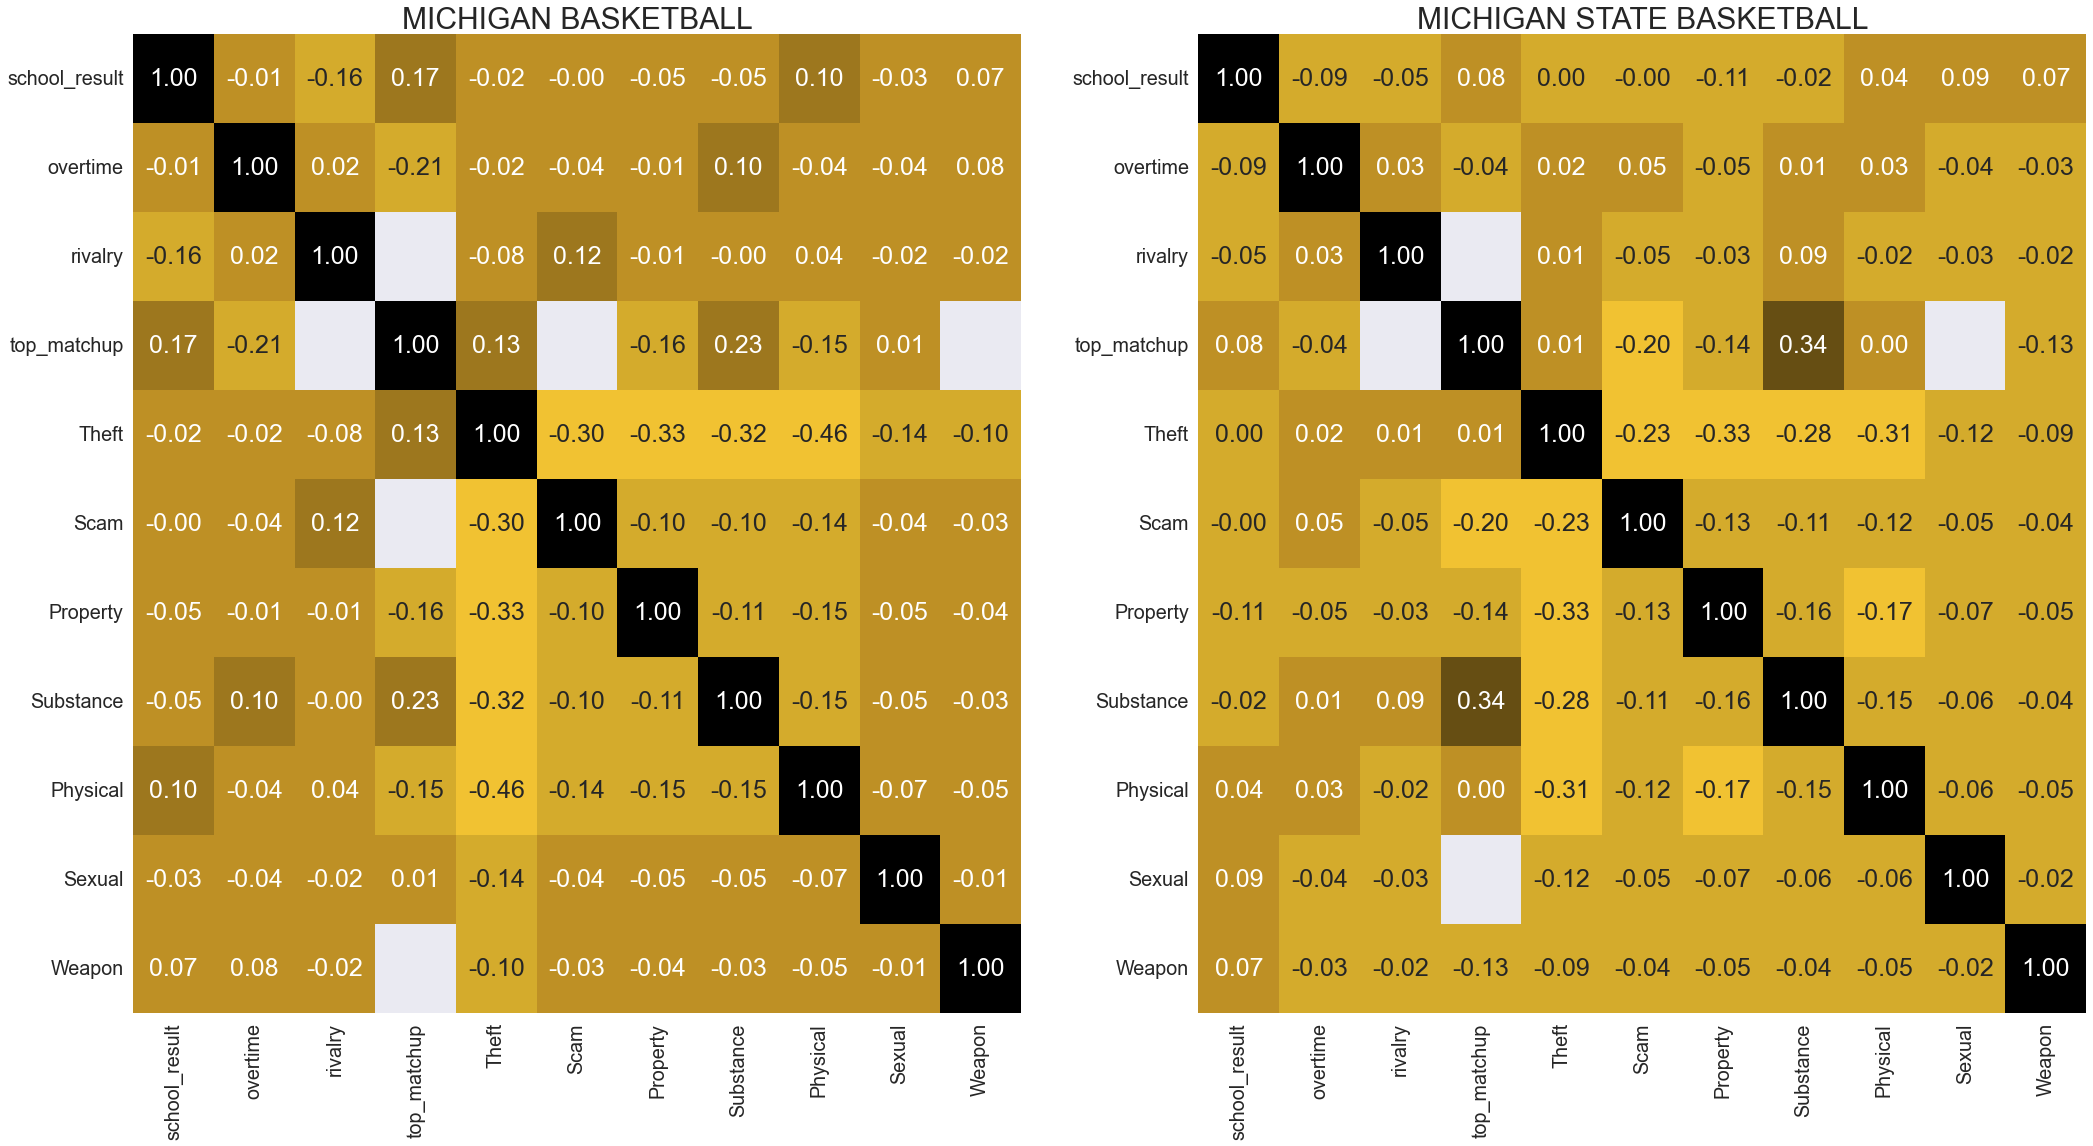

In [292]:
# condensed_lst = ['school_result', 'overtime','rivalry','top_matchup','Theft','Scam','Property','Substance Violation', 'Physical', 'Sexual', 'Weapon Violation']
sns.set(font_scale=1.8)

fig, axes =  plt.subplots( 1,2, figsize=(35, 18))

axes = axes.flatten()
plt.rcParams["axes.labelsize"]=20
for idx, school in enumerate(['michigan', 'michigan state']):
    if idx==0:
        cbar=False
    else:
        cbar=True
    
    sns.heatmap(((df_corr[(df_corr['sport'] == 'basketball') 
                            & (df_corr['school'] == school)]
                 )[condensed_lst]
                    )
                    .corr(method='spearman'), 
                    cmap=corr_map,
                    # cmap=sns.diverging_palette(16, 240, s=100, l=50, as_cmap=True), 
                    cbar=False,
                    annot=True,
                    fmt='.2f',
                    annot_kws={"fontsize":25},
                    ax= axes[idx]
                   )

    axes[idx].set_title(f'{school.upper()} BASKETBALL', fontsize=30)
    

plt.savefig('../../cbb_matrix.png')

<a id='distributions'></a>


&nbsp;

## Distributions


In [294]:
for rank in rank_list:
    print('top ' + str(rank))
    print(df_onerow[(df_onerow['top_' + str(rank) + '_matchup'] == 1) 
                    & (df_onerow['sport'] == 'football')]
          ['incident_count']
          .describe(), '\n')

top 25
count    51.000000
mean     14.039216
std       8.128864
min       0.000000
25%       8.000000
50%      13.000000
75%      20.000000
max      35.000000
Name: incident_count, dtype: float64 

top 20
count    40.000000
mean     13.775000
std       7.664395
min       3.000000
25%       8.000000
50%      13.000000
75%      18.500000
max      35.000000
Name: incident_count, dtype: float64 

top 15
count    21.000000
mean     14.190476
std       7.373053
min       5.000000
25%       8.000000
50%      13.000000
75%      17.000000
max      35.000000
Name: incident_count, dtype: float64 

top 10
count    11.000000
mean     17.090909
std       7.595453
min       8.000000
25%      13.000000
50%      14.000000
75%      20.500000
max      35.000000
Name: incident_count, dtype: float64 

top 5
count     2.000000
mean     18.000000
std       7.071068
min      13.000000
25%      15.500000
50%      18.000000
75%      20.500000
max      23.000000
Name: incident_count, dtype: float64 



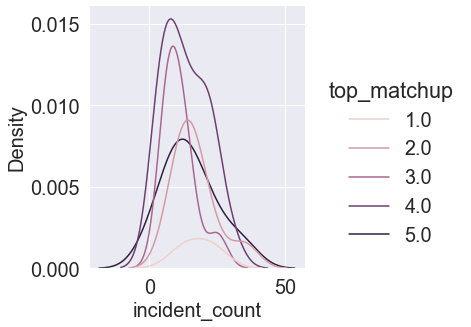

In [295]:
sns.displot(df_onerow[df_onerow['sport'] == 'football'], x='incident_count', hue='top_matchup', kind='kde')

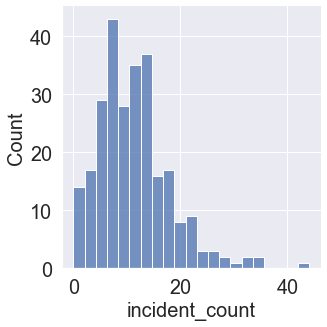

In [296]:
sns.displot(df_onerow[df_onerow['sport'] == 'football'], x='incident_count')

In [297]:
df[df['sport'] == 'football']['incident_hour'].value_counts()

0.0     320
23.0    307
22.0    253
1.0     242
20.0    221
19.0    214
17.0    211
21.0    203
2.0     194
18.0    177
16.0    173
12.0    173
14.0    106
15.0    100
13.0     76
3.0      49
4.0      20
5.0      10
6.0       5
Name: incident_hour, dtype: int64

/Users/davidboudia/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='top_matchup', ylabel='incident_count'>

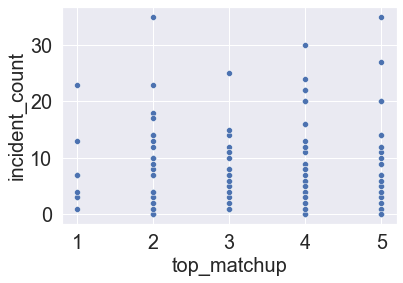

In [298]:
# scatterplot of high-incident games vs. hour
sns.scatterplot(df_onerow['top_matchup'], df_onerow['incident_count'])

<AxesSubplot:xlabel='incident_hour', ylabel='Count'>

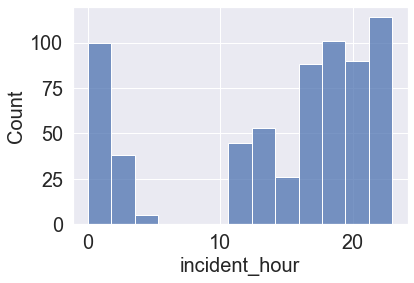

In [299]:
sns.histplot(df[(df['rivalry'] == 1) & (df['sport'] == 'football')]['incident_hour'])

In [300]:
df['offense_name'] = df['offense_name'].replace(np.nan, '99')

In [301]:
# correlation of crime with hour
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(list(df['offense_name']))
df['off_value'] = enc.transform(df['offense_name'])

<AxesSubplot:xlabel='school_points', ylabel='Count'>

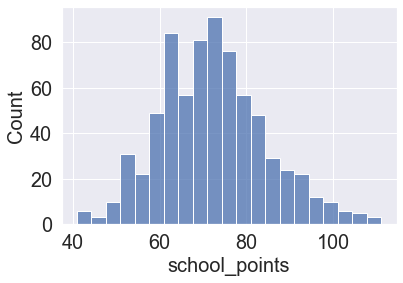

In [302]:
sns.histplot(df_onerow[df_onerow['sport'] == 'basketball']['school_points'])

<AxesSubplot:xlabel='school_points', ylabel='Count'>

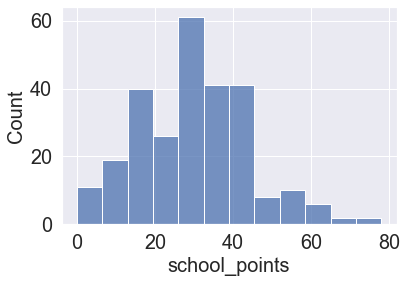

In [303]:
sns.histplot(df_onerow[df_onerow['sport'] == 'football']['school_points'])

In [304]:
print(df_onerow[df_onerow['sport'] == 'football']['school_points'].mean())
print(df_onerow[df_onerow['sport'] == 'football']['school_points'].std())

29.816479400749063
14.491118292364323


<AxesSubplot:xlabel='score_diff', ylabel='Count'>

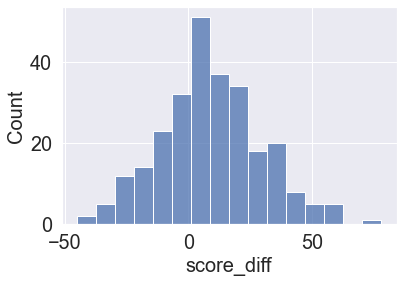

In [305]:
sns.histplot(df_onerow[df_onerow['sport'] == 'football']['score_diff'])

In [306]:
(df_onerow[df_onerow['sport'] == 'football']['score_diff']).describe()

count    267.000000
mean       9.318352
std       20.840059
min      -45.000000
25%       -3.000000
50%        7.000000
75%       23.000000
max       78.000000
Name: score_diff, dtype: float64

In [307]:
df_onerow[df_onerow['sport'] == 'football']['incident_count'].describe()

count    267.000000
mean      11.438202
std        6.764494
min        0.000000
25%        7.000000
50%       11.000000
75%       14.000000
max       44.000000
Name: incident_count, dtype: float64

<AxesSubplot:xlabel='incident_count', ylabel='Count'>

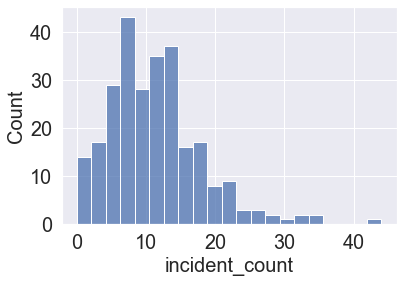

In [308]:
sns.histplot(df_onerow[df_onerow['sport'] == 'football']['incident_count'])

## Time Evaluation

In [309]:
df['hour_start'] = df['start'].dt.hour
df_grp = df.groupby(['hour_start','incident_hour'])[['incident_id']].agg('count').reset_index()
test = alt.Chart(df_grp[df_grp['hour_start']>0]).mark_rect().encode(
    x=alt.X('incident_hour:O', title="Hour of Incident Occurrence"),
    y=alt.Y('hour_start:O', sort=[x for x in range(23,12, -1)],
           title='Starting Hour of Game'),
    color=alt.Color('incident_id:Q',
                    scale=alt.Scale(range=['#f1c232','#000000'])
                   )
)

test.properties(width=800,height=500, title="Game Start Times and Hour of Incidence Occurence")


alt.Chart(...)

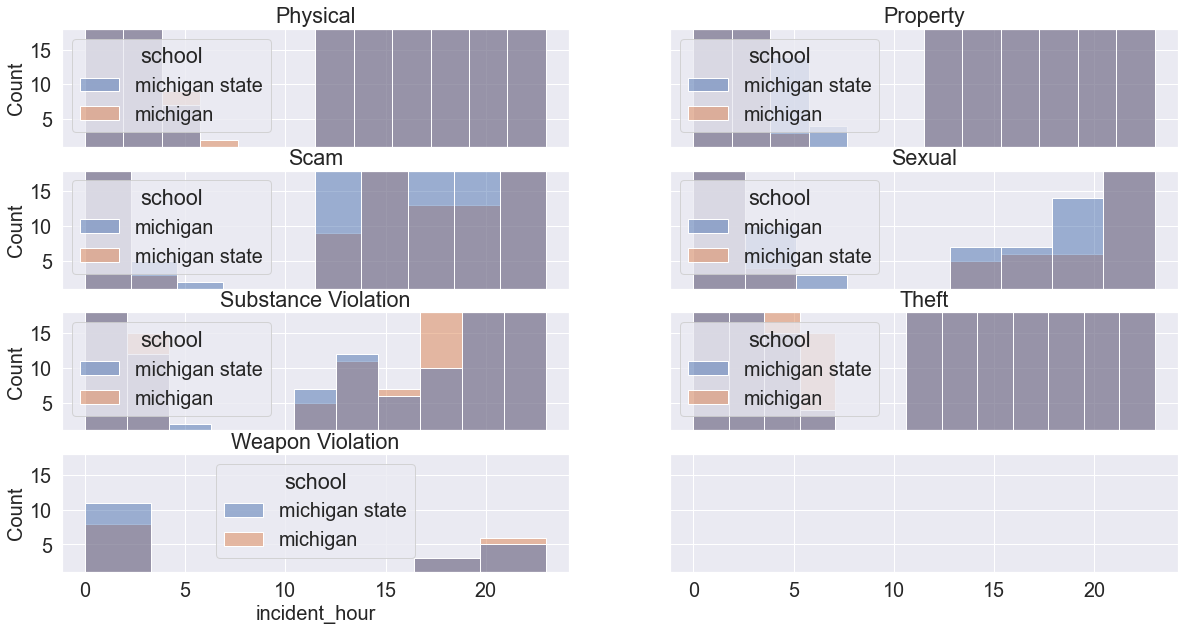

In [311]:
fig, axes = plt.subplots(4,2, figsize=(20,10), sharex=True, sharey=True)
axes = axes.flatten()
offenses = ['Physical', 'Property', 'Scam', 'Sexual', 'Substance Violation',
       'Theft', 'Weapon Violation']


for idx,crime in enumerate(offenses):
        crime_df = df[df[crime]==1]
        y_low = crime_df.incident_hour.value_counts().min()
        y_high = crime_df.incident_hour.value_counts().max() + 10
        axes[idx].set_title(f'{crime}')
        chart = sns.histplot(x='incident_hour',  hue='school',
                    data=crime_df, ax=axes[idx])
        chart.set_ybound(y_low,y_high)
        

In [312]:
df.columns

Index(['sport', 'school', 'opponent', 'game_id', 'start', 'incident_date',
       'end_window', 'type', 'school_result', 'school_points',
       'opponent_points', 'overtime', 'excitement_index', 'school_rank',
       'opponent_rank', 'attendance', 'venue', 'incident_id', 'offense_id',
       'offense_name', 'score_diff', 'incident_hour', 'incident_month',
       'incident_count', 'offense_map', 'Animal Cruelty', 'Physical',
       'Property', 'Scam', 'Sexual', 'Substance Violation', 'Theft',
       'Weapon Violation', 'Property sum', 'Physical sum', 'Theft sum',
       'Substance Violation sum', 'Scam sum', 'Sexual sum',
       'Weapon Violation sum', 'Animal Cruelty sum', 'top_25_matchup',
       'top_20_matchup', 'top_15_matchup', 'top_10_matchup', 'top_5_matchup',
       'poll_diff', 'score_quantile', 'venue_enc', 'top_matchup', 'rivalry',
       'off_value', 'hour_start'],
      dtype='object')

In [313]:
# offenses = ['Physical', 'Property', 'Scam', 'Sexual', 'Substance Violation',
#        'Theft', 'Weapon Violation']


    



crimes = df.groupby(['incident_month','offense_name'])['incident_count'].sum().reset_index()
crimes['offense_name'] = crimes['offense_name'].map(offense_groups)



mos = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',8:'Aug',9:'Sep',
      10:'Oct',11:'Nov',12:'Dec'}
crimes['incident_month'] = crimes['incident_month'].map(mos)




crimes = crimes[(crimes['offense_name'].isna()== False) & 
                (crimes['offense_name'] != 'Animal Cruelty')] 

test = alt.Chart(crimes).mark_rect().encode(
    x=alt.X('incident_month:O', title="Month",
           sort=['Jan','Feb','Mar','Apr','Aug','Sep','Oct','Nov','Dec']),
    y=alt.Y('offense_name:O',
           title='Offense Category'),
    color=alt.Color('incident_count:Q',
                    scale=alt.Scale(range=['#f1c232','#000000'])
                   )
)



test.properties(width=800,height=500, title="Incidents by Category and Month")




alt.Chart(...)

In [314]:
crimes[crimes['offense_name'].isna()==True].shape

(0, 3)

In [318]:
df_grp = df.groupby(['hour_start','incident_hour'])[['incident_id']].agg('count').reset_index()


In [319]:
df_grp = df.groupby(['hour_start','incident_hour'])[['incident_id']].agg('count').reset_index()

In [320]:
df_grp

,hour_start,incident_hour,incident_id
0,0,1.0,1
1,12,12.0,220
2,12,13.0,112
3,12,14.0,138
4,12,15.0,154
...,...,...,...
119,22,3.0,3
120,22,5.0,1
121,22,7.0,1
122,22,22.0,2


In [321]:
df[(df['hour_start']==12) & (df['incident_hour']==12)].shape

(220, 53)

In [322]:
offenses = ['Physical', 'Property', 'Scam', 'Sexual', 'Substance Violation',
       'Theft', 'Weapon Violation']
for offense in offenses:
    crime_df = df.groupby(offense)['incident_hour'].count()
    print(crime_df)


Physical
0    5544
1    1146
Name: incident_hour, dtype: int64
Property
0    5456
1    1234
Name: incident_hour, dtype: int64
Scam
0    6237
1     453
Name: incident_hour, dtype: int64
Sexual
0    6508
1     182
Name: incident_hour, dtype: int64
Substance Violation
0    6096
1     594
Name: incident_hour, dtype: int64
Theft
0    3659
1    3031
Name: incident_hour, dtype: int64
Weapon Violation
0    6652
1      38
Name: incident_hour, dtype: int64


In [323]:
bar_data = df.groupby(['school','offense_map']
                     )[['offense_id']].count().reset_index()
bar_data = bar_data.sort_values(['school','offense_id'],ascending=False)
bar_data

,school,offense_map,offense_id
13,michigan state,Theft,1097
9,michigan state,Property,667
8,michigan state,Physical,461
12,michigan state,Substance Violation,288
10,michigan state,Scam,155
11,michigan state,Sexual,92
14,michigan state,Weapon Violation,21
6,michigan,Theft,1934
1,michigan,Physical,685
2,michigan,Property,567


In [324]:
bar_data =  bar_data[bar_data.offense_map != 'Animal Cruelty']

# Get the percentages of offenses by school and category
bar_data['pct'] = bar_data['offense_id'] / bar_data.groupby('school')['offense_id'].transform('sum')
bar_data

/var/folders/y2/s0rssrh12596xwpyfp42jb0h0000gn/T/ipykernel_96711/803640572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar_data['pct'] = bar_data['offense_id'] / bar_data.groupby('school')['offense_id'].transform('sum')


,school,offense_map,offense_id,pct
13,michigan state,Theft,1097,0.394462
9,michigan state,Property,667,0.239842
8,michigan state,Physical,461,0.165768
12,michigan state,Substance Violation,288,0.103560
10,michigan state,Scam,155,0.055735
11,michigan state,Sexual,92,0.033082
14,michigan state,Weapon Violation,21,0.007551
6,michigan,Theft,1934,0.496279
1,michigan,Physical,685,0.175776
2,michigan,Property,567,0.145497


In [325]:

sort=['Theft','Property','Physical','Substance Violation','Scam','Sexual','Weapon Violation']

um_bar = alt.Chart(bar_data[bar_data['school']=='michigan']).mark_bar().encode(
 x=alt.X('pct:Q', 
         title=None,
         sort='descending',
        axis=alt.Axis(tickSize=0,
                      labelOpacity=1,
                     )
        ),
    y = alt.Y('offense_map:N', 
              axis=alt.Axis(title=None,
                            tickOpacity=0,
                           labelFontSize=0,
                           labelOpacity=0,
                           labels=False),
              sort=sort),
    
    color=alt.value('#333399')
    
).properties(width=500,height=250)


middle = alt.Chart(bar_data).encode(
    y=alt.Y('offense_map:N',
            axis=alt.Axis(title=None,
                          labels=False),
            sort=sort
           ),
    text=alt.Text('offense_map:N',),
).mark_text(fontSize=20).properties(height=250)




msu_bar = alt.Chart(bar_data[bar_data['school']=='michigan state']).mark_bar().encode(
 x=alt.X('pct:Q',
         sort='ascending'
         ,title=None,
        axis=alt.Axis(tickSize=0,labelOpacity=1),
        # scale=alt.Scale(domain=[0,2000])
        ),
    
    y = alt.Y('offense_map:N',
              axis=alt.Axis(title=None,
                            tickOpacity=0,
                            
                            labels=False,
                           labelOpacity=0),
              sort=sort,
             title=None),
    color=alt.value('#18453B')
                       
).properties(width=500,height=250)





off_comparison =alt.hconcat(um_bar,middle,msu_bar, 
                            title=alt.TitleParams(text="Offenses by School and Category (2009-2019)", dx=420, fontSize=20, offset=20))
off_comparison.configure_axis(
    grid=False,
    labelFontSize=20,
    titleFontSize=20
).configure_view(
    strokeWidth=0
).configure_axis(grid=False,domain=False)

alt.HConcatChart(...)

In [326]:
ts_df = df_onerow.copy()
ts_df = ts_df.groupby(['school','incident_date'])[['incident_count']].max().reset_index(level=0)
piv_ts = ts_df.pivot(columns=['school'])
piv_ts.columns = ['michigan',
                  'michigan state']

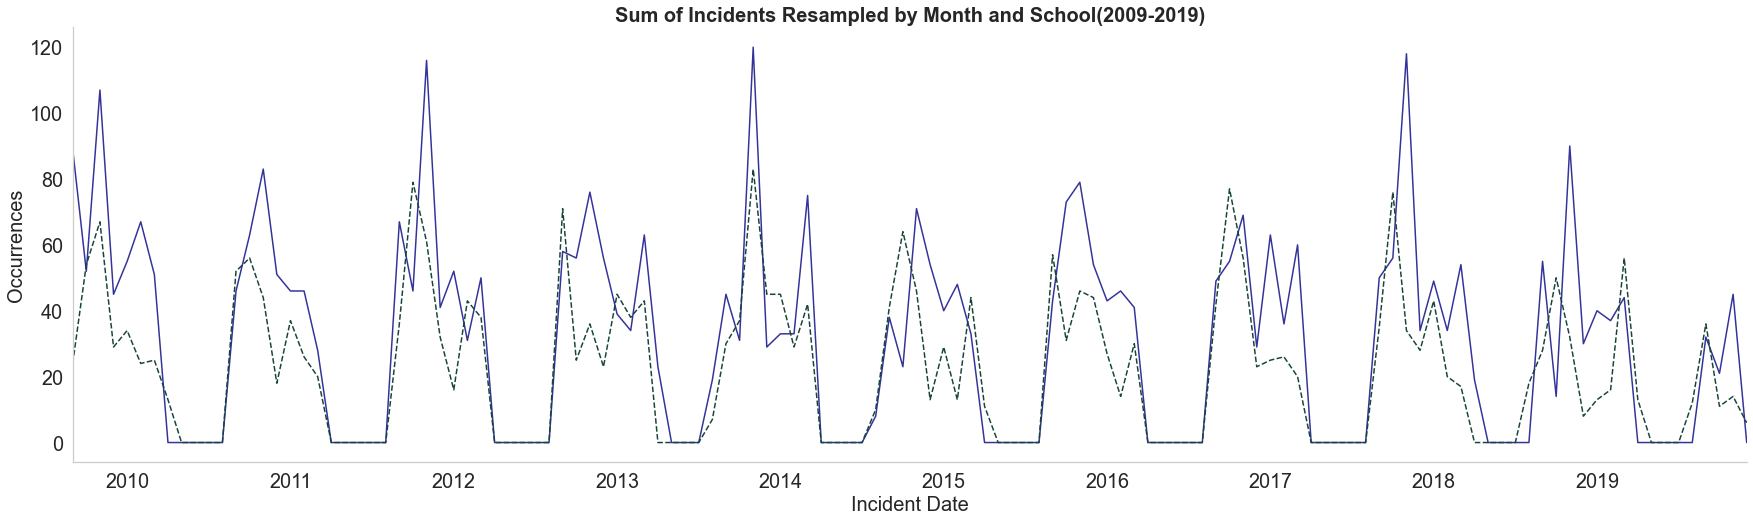

In [327]:
sns.set_style('whitegrid')

chart_data = piv_ts.resample('1M').sum()
ax = chart_data.plot(figsize=(30,8),
                     # style={'michigan':'dotted', 'michigan state':'dashed'},
                     style=['-','--'],
                     linewidth=1.5,
                      legend=True,
                      color=['#333399','#18453B'],
                     ).grid(False)

plt.title(fontdict={'fontsize': 20},label="Sum of Incidents Resampled by Month and School(2009-2019)",fontweight='bold')
plt.xlabel("Incident Date")
plt.ylabel("Occurrences")
plt.axis('on')
plt.legend().remove()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../../line.png', dpi=150) 